# analysis

In [1]:
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial import distance
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph

%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
graph_path = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'

graph = read_graph(weighted=False, 
               graph=graph_path,
               directed=False)

In [3]:
%%time
emb = n2i_nx_graph(nx_graph=graph, topics=3, tf=False)

CPU times: user 974 ms, sys: 37.8 ms, total: 1.01 s
Wall time: 848 ms


In [4]:
emb

{0: array([0.43182251, 1.59351425, 0.02717535]),
 1: array([0.3985025 , 1.68188378, 0.00850125]),
 2: array([0.53262376, 1.13394689, 0.22818202]),
 3: array([0.54338952, 1.15051291, 0.20061693]),
 4: array([0.47086669, 1.54664967, 0.02117078]),
 5: array([0.46784913, 1.55845817, 0.00871848]),
 6: array([0.46281141, 1.5203481 , 0.03932917]),
 7: array([0.46536562, 1.57488598, 0.        ]),
 8: array([0.48281395, 1.49641597, 0.03342143]),
 9: array([0.47576994, 1.47405615, 0.05701375]),
 10: array([0.58560891, 0.80533422, 0.39545079]),
 11: array([0.55710498, 0.57297603, 0.59577113]),
 12: array([0.55914141, 0.37471192, 0.7337974 ]),
 13: array([0.64217476, 0.53228542, 0.52505293]),
 14: array([0.57808477, 0.72563357, 0.46554577]),
 15: array([0.66902953, 0.58900304, 0.44687711]),
 16: array([0.40288654, 0.39148388, 0.92467901]),
 17: array([0.33659877, 0.42738467, 0.98014752]),
 18: array([0.45510079, 0.27023353, 0.93609665]),
 19: array([0.50330651, 0.18079642, 0.94174506]),
 20: array

In [5]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 10000)

In [6]:
graph = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'
G = read_graph(weighted=False, 
               graph=graph,
               directed=False)
p_val = [0.1, 0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2, 4, 8, 10, 20, 40]
q_val = [0.1, 0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2, 4, 8, 10, 20, 40]

topics=[15]
dimensions=[128]
walk_length=[80]
num_walks=[10]
window_size=[10]
iiter=[1]

In [7]:
args_list = []

nr_experiments = 20

for t in topics:
    for d in dimensions:
        for wk in walk_length:
            for n in num_walks:
                for wi in window_size:
                    for ii in iiter:
                        for p in p_val:
                            for q in q_val:
                                for seed in range(nr_experiments):
                                    args = [t, d, wk, n, wi, ii, p, q, seed]
                                    args_list.append(args)

In [8]:
def run_experiment(*args):
    t, d, wk, n, wi, ii, p, q, seed = args
    G_emb = n2i_nx_graph(nx_graph=G, topics=t, 
             dimensions=d, walk_length=wk,
             num_walks=n, window_size=wi,
             iiter=ii, p=p, q=q,
             seed = seed + int(1000*(q+p)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 5000)
    return args + (si/so,)

In [ ]:
result = list(map(lambda x: run_experiment(*x), args_list))

In [ ]:
df = pd.DataFrame(result, columns=['t', 'd', 'wk', 'n', 'wi', 'ii', 'p', 'q', 'seed', 'hom'])
df2 = df.groupby(['p', 'q'])['hom'].mean().unstack()

In [ ]:
df.loc()[[2420]]

In [ ]:
sns.heatmap(df2)
plt.title('Homophily (mean of 20 realizations)')

In [9]:
def analysis(graph, weighted, directed):
    '''
    Pipeline for the heatmap creation
    '''
    # read graph
    G = graph
    # experiments
    result = list(map(lambda x: run_experiment(*x), args_list))
    # df
    df = pd.DataFrame(result, columns=['t', 'd', 'wk', 'n', 'wi', 'ii', 'p', 'q', 'seed', 'hom'])
    df2 = df.groupby(['p', 'q'])['hom'].mean().unstack()
    
    return df2

Text(0.5,1,'Homophily (mean of 20 realizations)')

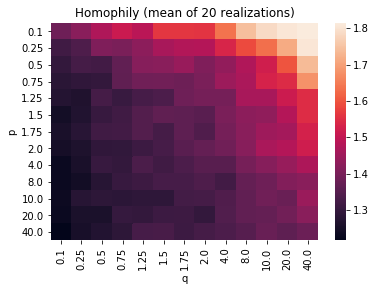

In [10]:
graph = nx.karate_club_graph()
weighted =  False if graph.edge_attr_dict_factory() == {} else True
directed = graph.is_directed()
df = analysis(graph, weighted, directed)

# plot
sns.heatmap(df)
plt.title('Homophily (mean of 20 realizations)')

# testing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
# Create one-vs-rest logistic regression object
clf = LogisticRegression(random_state=0, multi_class='ovr')
# Train model
model = clf.fit(X_std, y)

In [ ]:
new_observation = [[.5, .5, .5, .5]]
model.predict(new_observation)
model.predict_proba(new_observation)